# Finding the home of users
---
### Context
In the paper, "Friendship and mobility : User movement in Location-Based Social Networks", the authors answered one important question : what influence do friends have on movements ?<br>
The first step that the authors took was finding out the locations of the homes of each user and finding the distribution of the distance between friends' houses. In the present notebook, we will do the same for our new dataset.

---
### The data
“Global-scale Check-in Dataset with User Social Networks” from two research projects at this address (project 5 by Dingqi Yang): ( https://sites.google.com/site/yangdingqi/home/foursquare-dataset#h.p_7rmPjnwFGIx9). The dataset is coming from Foursquare and it contains the information of 22,809,624 checkins by 114,324 users, 607,333 friendship links and 3,820,891 POIs. It contains a set of worldwide check-ins with country flags taken over about two years and two snapshots of the corresponding user social network before (in Mar. 2012) and after (in May 2014) the check-in data collection period. <br>
In order to work with this dataset, we broke it down in smaller datasets, based on countries. In order to learn more on how we broke our dataset down, please consult the scripts "createSubDataset.ipynb" and "preprocess.ipynb".

---
### Structure of this notebook

This notebook is essentially the same as replicationUS.ipynb, the difference lies in the fact that we now compare data from multiple datasets. For more details on each step, consult the notebook replicationUS.ipynb

## Imports

In [1]:
import warnings
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
from zipfile import ZipFile
import math
data_path = 'data/'# '../data.zip/data/'
#data_file = ZipFile('../data.zip') # Uncomment this line only if you are Clement
#raw_dataset_file = ZipFile("../dataset_WWW2019.zip") # Uncomment this line only if you are Clement
warnings.simplefilter(action='ignore')

### Helper functions

In [43]:
# Helper function which finds the distance between two points from their latitude and longitude coordinates
# They are used later.

def find_distance(lat1, lat2, lon1, lon2):
    ### This fonction takes four columns of a dataframe and returns the column with all the distances
    ### calculated point by point.
    earth_radius = 6373 # In km
    lat1 = lat1/180 * math.pi
    lat2 = lat2/180 * math.pi
    dlat = lat2 - lat1
    dlon = (lon1 - lon2)/180 * math.pi
    a = (dlat/2).apply(math.sin)**2 + lat1.apply(math.cos) * lat2.apply(math.cos) * (dlon/2).apply(math.sin)**2
    c = 2 * (a.apply(math.sqrt) / (1 - a).apply(math.sqrt)).apply(math.atan)
    d = earth_radius * c
    distance_db = pd.DataFrame(d).rename(columns = {0 : 'distance'})
    return(distance_db)


# For each user, we want to assign them to one square (the one in which they checked-in the most).*
# In order to do so, we create a column named "my_square" which gives the name of the square in which each column
# is in. We take latitude = 0 and longitude = 0 to be the centre of the origin square.
# The names of our 25km * 25km squares are chosen as the tuple (latitude, longitude)
# In order to make our code more compact we create a function to create our labeling of squares.

def square_label(my_dataframe):
    inter = pd.DataFrame()
    cos_latitude = (my_dataframe['latitude']/180 * math.pi).apply(math.cos)
    inter["rounded_latitude"] = (110.574 * (my_dataframe['latitude'])/25).apply(round)
    inter["rounded_longitude"] = (111.320 * cos_latitude* (my_dataframe['longitude'])/25).apply(round)
    inter_list = inter.values.tolist()
    my_dataframe['my_square'] = [tuple(val) for val in inter_list]
    return(my_dataframe)


# For each user, we get the number of times where they checked in in a given location. We associate the position
# of their home with the position of the location where they checked in the most.
# In case of a draw (a user checked in the same number of times in two locations), we average the position of the
# house over the position of the most checked in locations.

def find_homes_avg(dataframe):
    grouped_data = dataframe.groupby(["user", "my_square"]).count()
    grouped_data = grouped_data.reset_index().drop(columns = ["locid"])
    # We start by getting all the values where there was a draw. (Takes a few minutes)
    # We then extract just the columns "user" and "my_square" to work on them.
    draw_data = grouped_data.groupby("user").apply(lambda x: x.loc[x["time"] == x["time"].max()])
    draw_value = pd.DataFrame(draw_data[["user", "my_square"]].values).rename(columns = {0 : 'user', 1 : 'my_square'})
    return(draw_value)


# Once we have filtered our home data, we can do our average over the right "my_square"

def compute_house_position(dataframe, home_data):
    dataframe = dataframe.merge(home_data, how = "inner", left_on = ["user", "my_square"], right_on = ["user", "my_square"])
    return(dataframe.groupby("user")[["latitude", "longitude"]].mean())


# At first, we think of doing a left join between our edge dataset and our house position dataframe. 
# We however realize that some users never checked in and therefore have no addresses.
# As a result, we decide to do an inner join.

def join_homes_and_user(dataframe, home_data):
    first_join = dataframe.merge(home_data, left_on = "friend", right_on = "user").rename(columns = {"latitude" : "friend latitude", "longitude" : "friend longitude"})
    second_join = first_join.merge(home_data, left_on = "pal", right_on = "user").rename(columns = {"latitude" : "pal latitude", "longitude" : "pal longitude"})
    return(second_join)

In [44]:
# We create a routine to open a dataframe and to compute all the distances between friends' houses. In order to do
# so, we use the helper functions coded above.

def distance_db_avg(df_friend, dataframe):
    # loading the data
    checkins = pd.read_csv(data_path+dataframe, names=['locid','user', 'time','year',  'latitude', 'longitude', 'building', 'countries'],header=None, error_bad_lines=False)
    # Uncomment the following line only if you are Clement
    #checkins = pd.read_csv(data_file.open('data/'+dataframe), names=['locid','user', 'time','year',  'latitude', 'longitude', 'building', 'countries'],header=None, error_bad_lines=False)
    
    # convert string to number
    checkins.drop(0,0,inplace=True)
    checkins.user = checkins.user.astype(int)
    checkins.latitude = checkins.latitude.astype(float)
    checkins.longitude = checkins.longitude.astype(float)
    
    # Extracting useful informations (House location)
    checkins = square_label(checkins)
    home_data_avg = find_homes_avg(checkins)
    home_positions_avg = compute_house_position(checkins, home_data_avg)
    home_positions_avg = home_positions_avg.reset_index()
    
    # merge on the friend dataframe
    df_friend.merge(home_positions_avg, left_on = "friend", right_on = "user").merge(home_positions_avg, left_on = "pal", right_on = "user")
    friend_home_df_avg = join_homes_and_user(df_friend, home_positions_avg)
    distance_db_avg = find_distance(friend_home_df_avg["friend latitude"], friend_home_df_avg["pal latitude"], friend_home_df_avg["friend longitude"], friend_home_df_avg["pal longitude"])
    return distance_db_avg

In [45]:
df_friend = pd.read_csv(data_path+'dataset_WWW_friendship_new.txt', header = None, sep = "\t", names = ["friend", "pal"])
#df_friend = pd.read_csv(raw_dataset_file.open('dataset_WWW2019/dataset_WWW_friendship_new.txt'), header = None, sep = "\t", names = ["friend", "pal"])
US_distance_db_avg  = distance_db_avg(df_friend, '1_US_2013_merge_data.csv')
PH_distance_db_avg  = distance_db_avg(df_friend, '10_PH_2013_merge_data.csv')
ID_distance_db_avg  = distance_db_avg(df_friend, '2_ID_2013_merge_data.csv')
BR_distance_db_avg  = distance_db_avg(df_friend, '3_BR_2013_merge_data.csv')
TR_distance_db_avg  = distance_db_avg(df_friend, '4_TR_2013_merge_data.csv')
RU_distance_db_avg  = distance_db_avg(df_friend, '5_RU_2013_merge_data.csv')
JP_distance_db_avg  = distance_db_avg(df_friend, '6_JP_2013_merge_data.csv')
MY_distance_db_avg  = distance_db_avg(df_friend, '7_MY_2013_merge_data.csv')
MX_distance_db_avg  = distance_db_avg(df_friend, '8_MX_2013_merge_data.csv')
TH_distance_db_avg  = distance_db_avg(df_friend, '9_TH_2013_merge_data.csv')

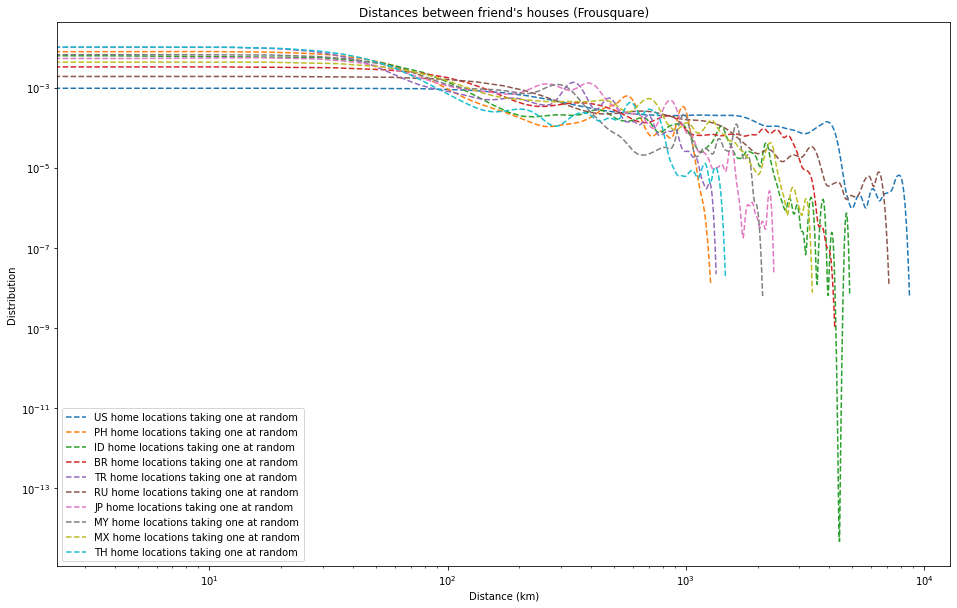

In [46]:
# We compare the distance between houses with our multiple dataframes of houses locations.

fig, ax = plt.subplots(figsize = (16, 10))
sns.kdeplot(US_distance_db_avg["distance"],ax = ax, common_norm = True, fill = False, linestyle = "--", legend = True, label = 'US home locations taking one at random')
sns.kdeplot(PH_distance_db_avg["distance"],ax = ax, common_norm = True, fill = False, linestyle = "--", legend = True, label = 'PH home locations taking one at random')
sns.kdeplot(ID_distance_db_avg["distance"],ax = ax, common_norm = True, fill = False, linestyle = "--", legend = True, label = 'ID home locations taking one at random')
sns.kdeplot(BR_distance_db_avg["distance"],ax = ax, common_norm = True, fill = False, linestyle = "--", legend = True, label = 'BR home locations taking one at random')
sns.kdeplot(TR_distance_db_avg["distance"],ax = ax, common_norm = True, fill = False, linestyle = "--", legend = True, label = 'TR home locations taking one at random')
sns.kdeplot(RU_distance_db_avg["distance"],ax = ax, common_norm = True, fill = False, linestyle = "--", legend = True, label = 'RU home locations taking one at random')
sns.kdeplot(JP_distance_db_avg["distance"],ax = ax, common_norm = True, fill = False, linestyle = "--", legend = True, label = 'JP home locations taking one at random')
sns.kdeplot(MY_distance_db_avg["distance"],ax = ax, common_norm = True, fill = False, linestyle = "--", legend = True, label = 'MY home locations taking one at random')
sns.kdeplot(MX_distance_db_avg["distance"],ax = ax, common_norm = True, fill = False, linestyle = "--", legend = True, label = 'MX home locations taking one at random')
sns.kdeplot(TH_distance_db_avg["distance"],ax = ax, common_norm = True, fill = False, linestyle = "--", legend = True, label = 'TH home locations taking one at random')
plt.gca().set_xscale("log")
plt.gca().set_yscale("log")
plt.title("Distances between friend's houses (Frousquare)")
plt.ylabel("Distribution")
plt.xlabel("Distance (km)")
ax.legend()
plt.show()

### Conclusion
When comparing the distribution of distances between friends' houses, we notice that the countries with the smallest surfaces are the ones where the probabilities of having friends living far away is the lowest. Indeed, for example, for Turkey, there are no friends living at a distance bigger than 10^3. When we look at the distance between Turkish cities (https://distancecalculator.globefeed.com/Turkey_Distance_Calculator.asp), we notice that most of them are smaller than 10^3. We observe similar results for other countries.

### Part 2 Find by country the maximum distance between two friends

In [47]:
print("the maximum distance between two friends in US {} km".format(max(US_distance_db_avg["distance"].astype(int))))
print("the maximum distance between two friends in PH {} km".format(max(PH_distance_db_avg["distance"].astype(int))))
print("the maximum distance between two friends in ID {} km".format(max(ID_distance_db_avg["distance"].astype(int))))
print("the maximum distance between two friends in BR {} km".format(max(BR_distance_db_avg["distance"].astype(int))))
print("the maximum distance between two friends in TR {} km".format(max(TR_distance_db_avg["distance"].astype(int))))
print("the maximum distance between two friends in RU {} km".format(max(RU_distance_db_avg["distance"].astype(int))))
print("the maximum distance between two friends in JP {} km".format(max(JP_distance_db_avg["distance"].astype(int))))
print("the maximum distance between two friends in MY {} km".format(max(MY_distance_db_avg["distance"].astype(int))))
print("the maximum distance between two friends in TH {} km".format(max(TH_distance_db_avg["distance"].astype(int))))

the maximum distance between two friends in US 8210 km
the maximum distance between two friends in PH 1156 km
the maximum distance between two friends in ID 4725 km
the maximum distance between two friends in BR 3982 km
the maximum distance between two friends in TR 1267 km
the maximum distance between two friends in RU 6687 km
the maximum distance between two friends in JP 2247 km
the maximum distance between two friends in MY 1985 km
the maximum distance between two friends in TH 1377 km


### Part 3 Find the number of foreign friends

In [2]:
df_friend = pd.read_csv(data_path+'dataset_WWW_friendship_new.txt', header = None, sep = "\t", names = ["friend", "pal"])
checkins = pd.read_csv(data_path+'1_US_2013_merge_data.csv', names=['locid','user', 'time','year',  'latitude', 'longitude', 'building', 'countries'],header=None, error_bad_lines=False)
# convert string to number
checkins.drop(0,0,inplace=True)
checkins.user = checkins.user.astype(int)
checkins.latitude = checkins.latitude.astype(float)
checkins.longitude = checkins.longitude.astype(float)

US_participants = checkins.groupby(by = "user").agg("count")
list_of_people_with_homes = checkins[checkins["building"] == "Home (private)"].user.unique().tolist()
US_natives = checkins[checkins["user"].isin(list_of_people_with_homes)]
US_foreign = checkins[~checkins.user.isin(list_of_people_with_homes)]

print('Our initial dataset had {} users.'.format(US_participants.shape[0]))
print('Out of them, {} are considered natives.'.format(len(US_natives.user.unique().tolist())))
print('Out of them, {} are considered foreigners.'.format(len(US_foreign.user.unique().tolist())))

Our initial dataset had 20495 users.
Out of them, 5364 are considered natives.
Out of them, 15131 are considered foreigners.


In [3]:
#df_friend = df_friend[df_friend.friend == US_natives.user]
df_friend = df_friend.reset_index(drop=True)
US_natives = US_natives.reset_index(drop=True)
df_friend.merge(US_natives, left_on = "friend", right_on = "user").merge(US_foreign, left_on = "pal", right_on = "user")
df_friend

,friend,pal
0,15,595326
1,19,54
2,19,1061
3,19,1668
4,19,21596
...,...,...
607328,2166684,2181580
607329,2167183,2175735
607330,2170360,2174239
607331,2173716,2186144


<AxesSubplot:title={'center':'Number of friends of foreign users (new)'}>

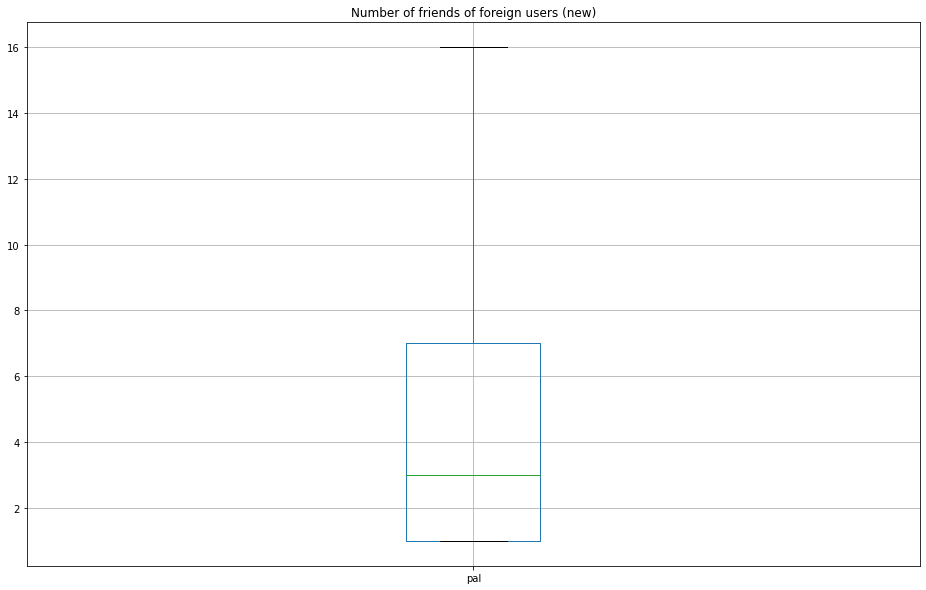

In [4]:
fig, ax = plt.subplots(figsize = (16, 10))
plt.title("Number of friends of foreign users (new)")
df_friend.groupby('friend').count().boxplot(column = ['pal'],showfliers=False)

In [2]:
#df_friend = pd.read_csv(data_path+'dataset_WWW_friendship_new.txt', header = None, sep = "\t", names = ["friend", "pal"])
def boxplotforeign(df_friend,dataframe):
    checkins = pd.read_csv(data_path+dataframe, names=['locid','user', 'time','year',  'latitude', 'longitude', 'building', 'countries'],header=None, error_bad_lines=False)
    # convert string to number
    checkins.drop(0,0,inplace=True)
    checkins.user = checkins.user.astype(int)
    checkins.latitude = checkins.latitude.astype(float)
    checkins.longitude = checkins.longitude.astype(float)

    participants = checkins.groupby(by = "user").agg("count")
    list_of_people_with_homes = checkins[checkins["building"] == "Home (private)"].user.unique().tolist()
    natives = checkins[checkins["user"].isin(list_of_people_with_homes)]
    foreign = checkins[~checkins.user.isin(list_of_people_with_homes)]
    print('Our initial dataset had {} users.'.format(participants.shape[0]))
    print('Out of them, {} are considered natives.'.format(len(natives.user.unique().tolist())))
    print('Out of them, {} are considered foreigners.'.format(len(foreign.user.unique().tolist())))
    friend = df_friend.reset_index(drop=True)
    natives = natives.reset_index(drop=True)
    friend.merge(natives, left_on = "friend", right_on = "user").merge(foreign, left_on = "pal", right_on = "user")
    nb_friends = []
    for i in range(20):
        sample_abb = foreign.sample(frac = 0.8, random_state = i)
        friend = friend[friend.friend.isin(sample_abb.index.tolist())]
        nb_friends.append(friend.shape[0]/len(friend.friend.unique()))
    nb_friends.sort()
    
    print("Natives have on average {} friends, our 90% confidence interval is[ {}, {}]".format(np.average(nb_friends), nb_friends[1], nb_friends[-2]))


    return friend

Our initial dataset had 20495 users.
Out of them, 5364 are considered natives.
Out of them, 15131 are considered foreigners.
Natives have on average 8.275800676314425 friends, our 90% confidence interval is[ 8.064853556485355, 8.540469973890339]


<AxesSubplot:title={'center':'Number of friends of foreign users (new)'}>

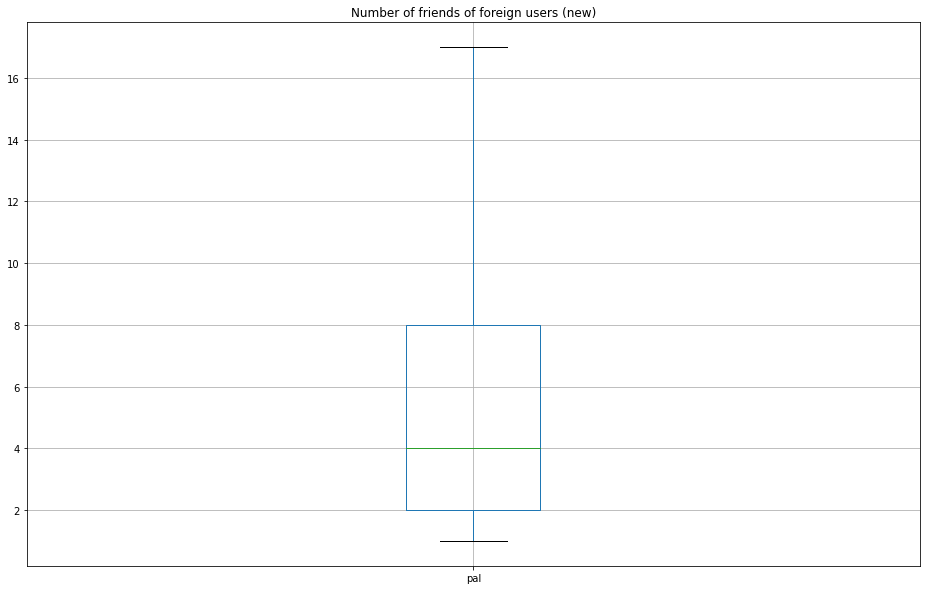

In [25]:
df_friend = pd.read_csv(data_path+'dataset_WWW_friendship_new.txt', header = None, sep = "\t", names = ["friend", "pal"])
fig, ax = plt.subplots(figsize = (16, 10))
plt.title("Number of friends of foreign users (new)")
US_foreign_friend  = boxplotforeign(df_friend, '1_US_2013_merge_data.csv')
US_foreign_friend.groupby('friend').count().boxplot(column = ['pal'],showfliers=False)

Our initial dataset had 3015 users.
Out of them, 1724 are considered natives.
Out of them, 1291 are considered foreigners.
Natives have on average 13.278495089567855 friends, our 90% confidence interval is[ 11.455328310010763, 16.788732394366196]


,friend,pal
1456,799,801
1457,799,806
1458,799,1268
1459,799,1532
1460,799,1536
...,...,...
187505,208292,330698
187506,208292,432659
190569,215087,343628
190570,215087,463367


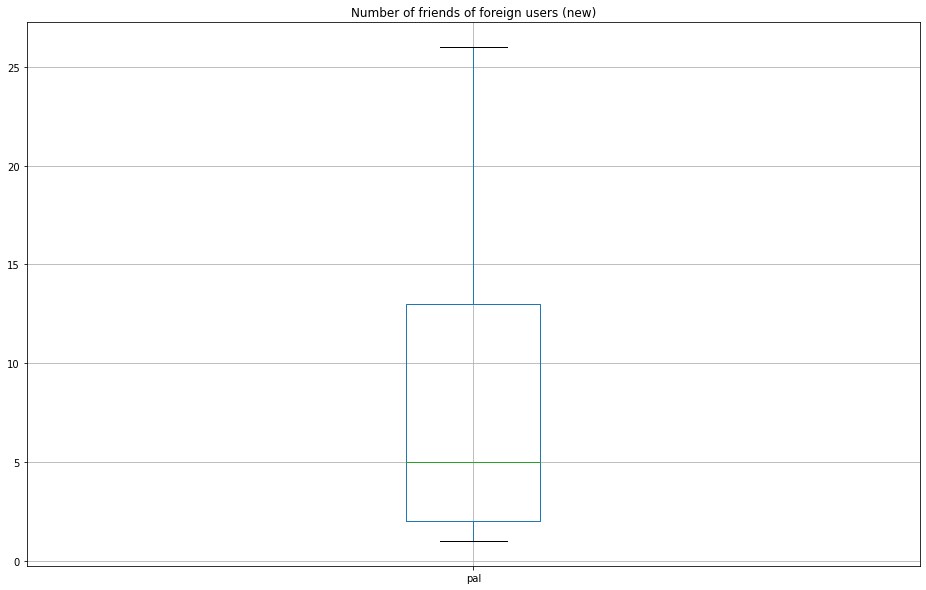

In [26]:

#df_friend = pd.read_csv(raw_dataset_file.open('dataset_WWW2019/dataset_WWW_friendship_new.txt'), header = None, sep = "\t", names = ["friend", "pal"])
df_friend = pd.read_csv(data_path+'dataset_WWW_friendship_new.txt', header = None, sep = "\t", names = ["friend", "pal"])
fig, ax = plt.subplots(figsize = (16, 10))
plt.title("Number of friends of foreign users (new)")
PH_foreign_friend  = boxplotforeign(df_friend, '10_PH_2013_merge_data.csv')
PH_foreign_friend.groupby('friend').count().boxplot(column = ['pal'],showfliers=False)
#PH_foreign_friend

Our initial dataset had 12542 users.
Out of them, 7371 are considered natives.
Out of them, 5171 are considered foreigners.
Natives have on average 9.937049459567742 friends, our 90% confidence interval is[ 9.451851851851853, 10.577272727272728]


<AxesSubplot:title={'center':'Number of friends of foreign users (new)'}>

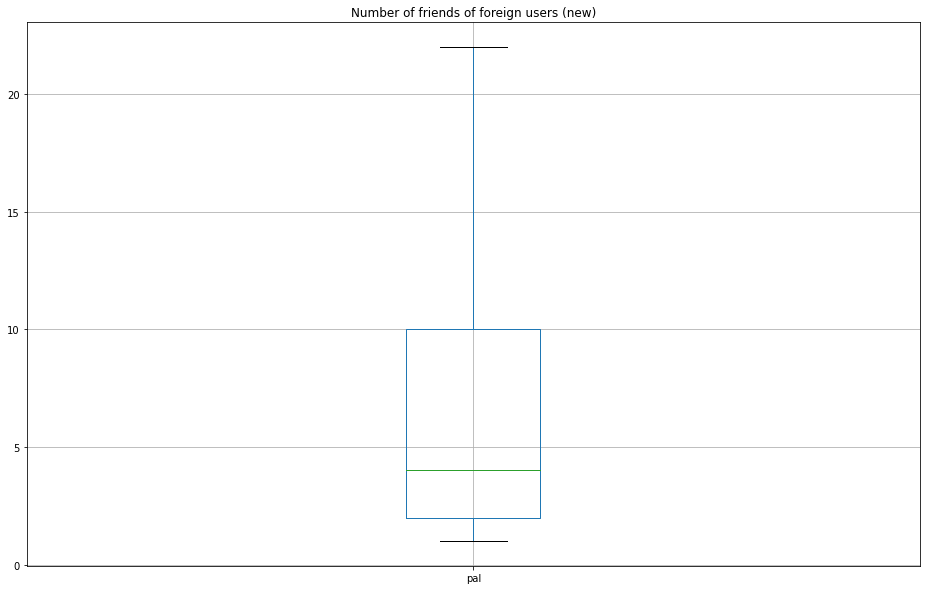

In [27]:
df_friend = pd.read_csv(data_path+'dataset_WWW_friendship_new.txt', header = None, sep = "\t", names = ["friend", "pal"])
fig, ax = plt.subplots(figsize = (16, 10))
plt.title("Number of friends of foreign users (new)")
ID_foreign_friend = boxplotforeign(df_friend, '2_ID_2013_merge_data.csv')
ID_foreign_friend.groupby('friend').count().boxplot(column = ['pal'],showfliers=False)

Our initial dataset had 12569 users.
Out of them, 7166 are considered natives.
Out of them, 5403 are considered foreigners.
Natives have on average 8.684888827728578 friends, our 90% confidence interval is[ 8.035108958837773, 9.26981883592445]


<AxesSubplot:title={'center':'Number of friends of foreign users (new)'}>

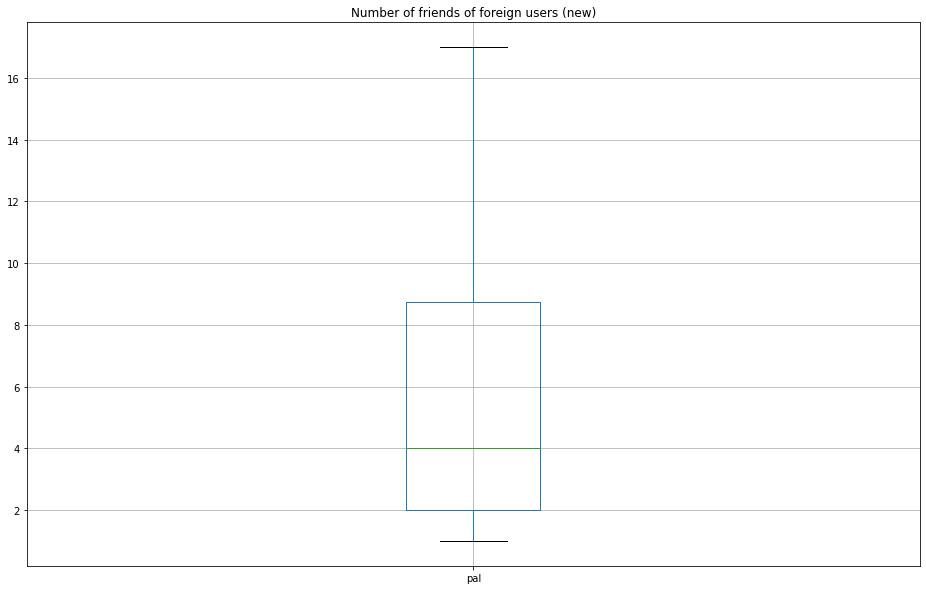

In [28]:
df_friend = pd.read_csv(data_path+'dataset_WWW_friendship_new.txt', header = None, sep = "\t", names = ["friend", "pal"])
fig, ax = plt.subplots(figsize = (16, 10))
plt.title("Number of friends of foreign users (new)")
BR_foreign_friend  = boxplotforeign(df_friend, '3_BR_2013_merge_data.csv')
BR_foreign_friend.groupby('friend').count().boxplot(column = ['pal'],showfliers=False)

Our initial dataset had 11781 users.
Out of them, 4798 are considered natives.
Out of them, 6983 are considered foreigners.
Natives have on average 9.670365910692002 friends, our 90% confidence interval is[ 9.256302521008404, 10.348]


<AxesSubplot:title={'center':'Number of friends of foreign users (new)'}>

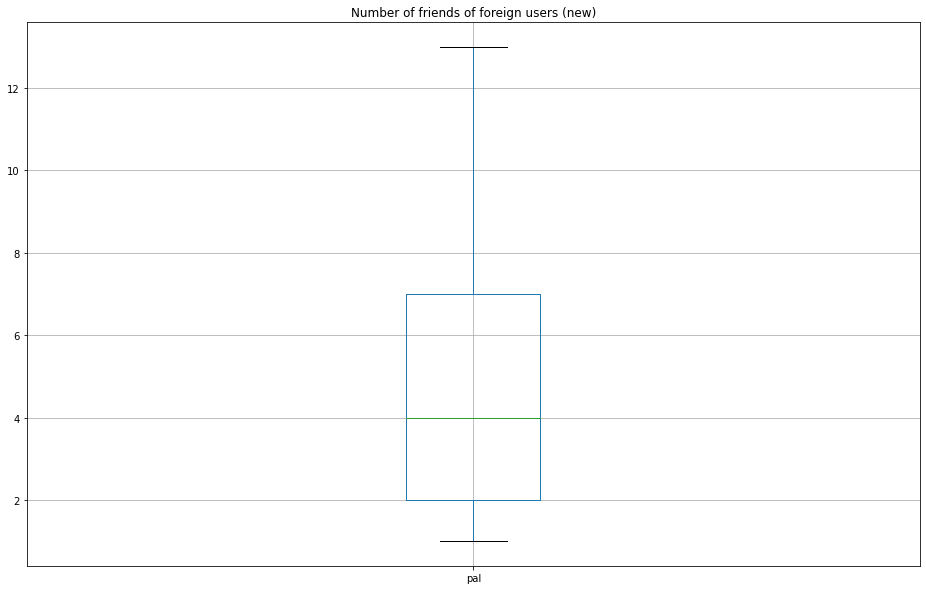

In [30]:
df_friend = pd.read_csv(data_path+'dataset_WWW_friendship_new.txt', header = None, sep = "\t", names = ["friend", "pal"])
fig, ax = plt.subplots(figsize = (16, 10))
plt.title("Number of friends of foreign users (new)")
TR_foreign_friend  = boxplotforeign(df_friend, '4_TR_2013_merge_data.csv')
TR_foreign_friend.groupby('friend').count().boxplot(column = ['pal'],showfliers=False)

Our initial dataset had 3380 users.
Out of them, 1604 are considered natives.
Out of them, 1776 are considered foreigners.
Natives have on average 11.243820235990633 friends, our 90% confidence interval is[ 10.057142857142857, 12.694805194805195]


<AxesSubplot:title={'center':'Number of friends of foreign users (new)'}>

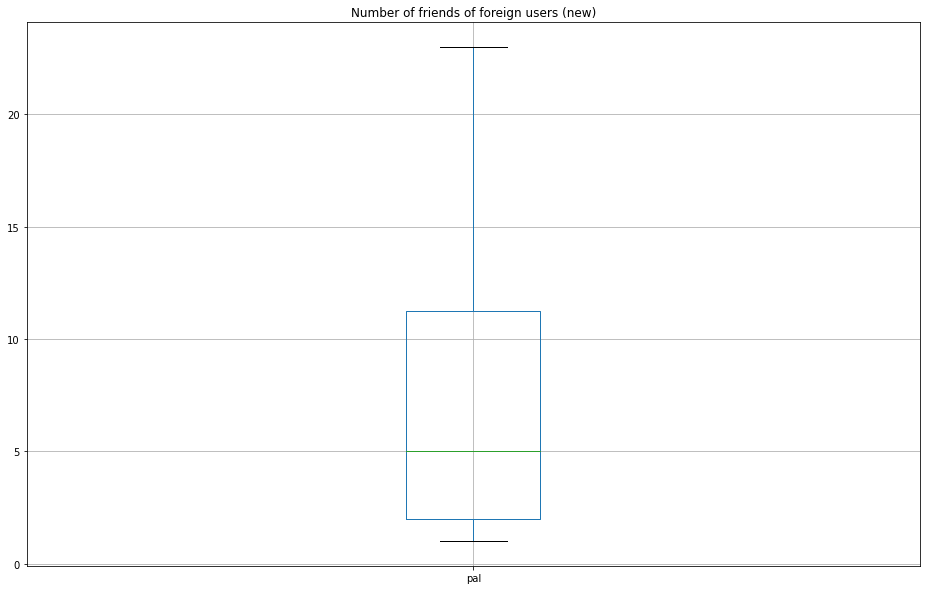

In [31]:
df_friend = pd.read_csv(data_path+'dataset_WWW_friendship_new.txt', header = None, sep = "\t", names = ["friend", "pal"])
fig, ax = plt.subplots(figsize = (16, 10))
plt.title("Number of friends of foreign users (new)")
RU_foreign_friend  = boxplotforeign(df_friend, '5_RU_2013_merge_data.csv')
RU_foreign_friend.groupby('friend').count().boxplot(column = ['pal'],showfliers=False)

In [ ]:
df_friend = pd.read_csv(data_path+'dataset_WWW_friendship_new.txt', header = None, sep = "\t", names = ["friend", "pal"])
fig, ax = plt.subplots(figsize = (16, 10))
plt.title("Number of friends of foreign users (new)")
JP_foreign_friend  = boxplotforeign(df_friend, '6_JP_2013_merge_data.csv')
JP_foreign_friend.groupby('friend').count().boxplot(column = ['pal'],showfliers=False)

Our initial dataset had 9245 users.
Out of them, 611 are considered natives.
Out of them, 8634 are considered foreigners.


Our initial dataset had 8064 users.
Out of them, 4247 are considered natives.
Out of them, 3817 are considered foreigners.
Natives have on average 10.234189139060536 friends, our 90% confidence interval is[ 9.430274135876044, 12.302013422818792]


<AxesSubplot:title={'center':'Number of friends of foreign users (new)'}>

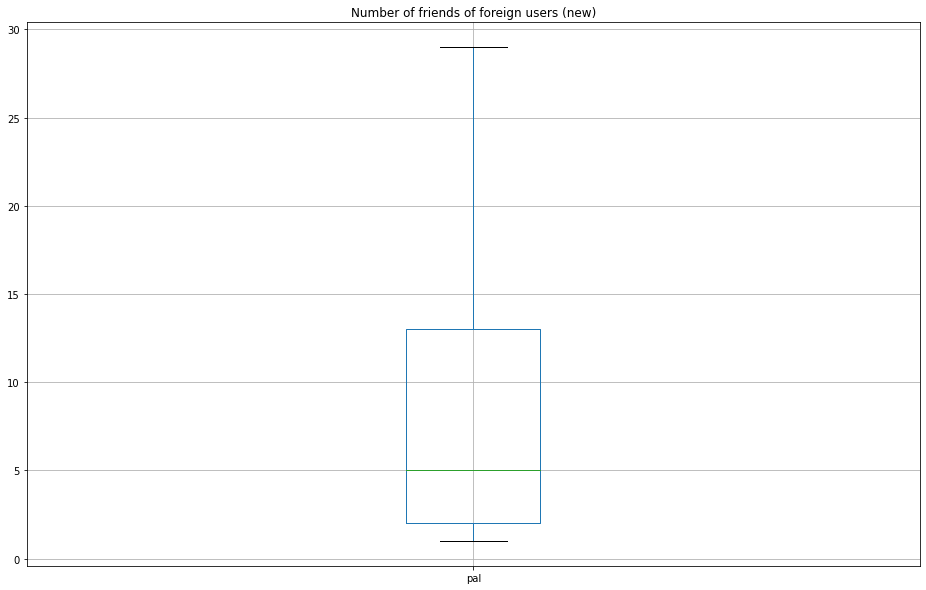

In [5]:
df_friend = pd.read_csv(data_path+'dataset_WWW_friendship_new.txt', header = None, sep = "\t", names = ["friend", "pal"])
fig, ax = plt.subplots(figsize = (16, 10))
plt.title("Number of friends of foreign users (new)")
MY_foreign_friend  = boxplotforeign(df_friend, '7_MY_2013_merge_data.csv')
MY_foreign_friend.groupby('friend').count().boxplot(column = ['pal'],showfliers=False)

Our initial dataset had 7445 users.
Out of them, 2547 are considered natives.
Out of them, 4898 are considered foreigners.
Natives have on average 10.089943067182272 friends, our 90% confidence interval is[ 9.527918781725889, 10.773170731707317]


<AxesSubplot:title={'center':'Number of friends of foreign users (new)'}>

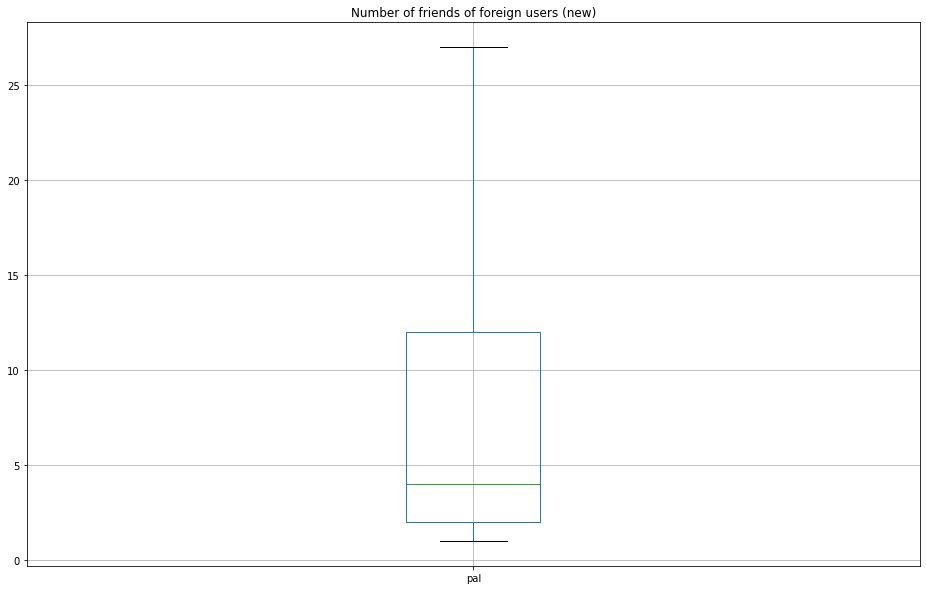

In [4]:
df_friend = pd.read_csv(data_path+'dataset_WWW_friendship_new.txt', header = None, sep = "\t", names = ["friend", "pal"])
fig, ax = plt.subplots(figsize = (16, 10))
plt.title("Number of friends of foreign users (new)")
MX_foreign_friend  = boxplotforeign(df_friend, '8_MX_2013_merge_data.csv')
MX_foreign_friend.groupby('friend').count().boxplot(column = ['pal'],showfliers=False)

Our initial dataset had 5531 users.
Out of them, 1977 are considered natives.
Out of them, 3554 are considered foreigners.
Natives have on average 12.820411676769819 friends, our 90% confidence interval is[ 10.791962532104547, 15.867724867724867]


<AxesSubplot:title={'center':'Number of friends of foreign users (new)'}>

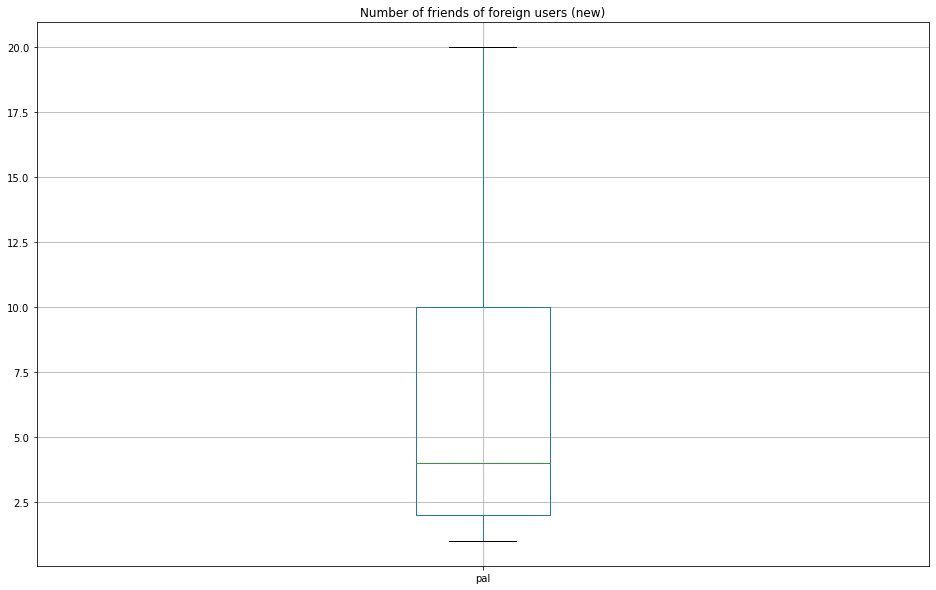

In [3]:

df_friend = pd.read_csv(data_path+'dataset_WWW_friendship_new.txt', header = None, sep = "\t", names = ["friend", "pal"])
fig, ax = plt.subplots(figsize = (16, 10))
plt.title("Number of friends of foreign users (new)")
TH_foreign_friend  = boxplotforeign(df_friend, '9_TH_2013_merge_data.csv')
TH_foreign_friend.groupby('friend').count().boxplot(column = ['pal'],showfliers=False)